# SAR for Forest Applications - Silva Cras

# Change Detection 

Josef Kellndorfer, Ph.D., President and Senior Scientist, Earth Big Data, LLC


In this chapter we introduce four methods for change detection based on

- Time series metrics  95$^{th}$ and 5$^{th}$ percentile difference thresholding
- Time series coefficient of variation (COV) thresholding
- Log Ratio from two image pairs
- Annual change in coefficient of variation

# Import Python modules

In [144]:
import os,sys,gdal
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches  # Needed to draw rectangles
from skimage import exposure # to enhance image display
import numpy as np
import pandas as pd
from sklearn import cluster # Clasificación final
from osgeo import gdal, gdal_array


# Select the Project data set and time series data

## Prueba Silva_Cras

In [126]:
datadirectory='C:/Users/crist/Documents/Python Scripts/1_servir_training-master/Prueba_PatNat/18NWG_20m_D_069'
datefile='18NWG_20m_D_069_vv_mtfil.dates'
imagefile='18NWG_20m_D_069_vv_mtfil.vrt'
mascara='BNB_2017_18NWG.tif'
subset=None


In [127]:
os.chdir(datadirectory)

We are defining two helper functions for this task

- **CreateGeoTiff()** to write out images
- **timeseries_metrics()** to compute various metrics from a time series data stack

In [145]:
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType,options=['PHOTOMETRIC=RGB'])
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        band=DataSet.GetRasterBand(i)
        band.SetNoDataValue(NDV)
        band.SetDescription(bandnames[i-1])
        band.WriteArray( image )
    DataSet.FlushCache()
    DataSet=None
    return Name

In [146]:
def timeseries_metrics(raster,ndv=0): 
    # Make us of numpy nan functions
    # Check if type is a float array
    if not raster.dtype.name.find('float')>-1:
        raster=raster.astype(np.float32)
    # Set ndv to nan
    if ndv != np.nan:
        raster[np.equal(raster,ndv)]=np.nan
    # Build dictionary of the metrics
    tsmetrics={}
    rperc = np.nanpercentile(raster,[5,50,95],axis=0)
    tsmetrics['mean']=np.nanmean(raster,axis=0)
    tsmetrics['max']=np.nanmax(raster,axis=0)
    tsmetrics['min']=np.nanmin(raster,axis=0)
    tsmetrics['range']=tsmetrics['max']-tsmetrics['min']
    tsmetrics['median']=rperc[1]
    tsmetrics['p5']=rperc[0]
    tsmetrics['p95']=rperc[2]
    tsmetrics['prange']=rperc[2]-rperc[0]
    tsmetrics['var']=np.nanvar(raster,axis=0)
    tsmetrics['cov']=tsmetrics['var']/tsmetrics['mean']
    return tsmetrics

## Set the Dates

In [6]:
# Get the date indices via pandas
dates=open(datefile).readlines()
tindex=pd.DatetimeIndex(dates)
tindexOrg=tindex
j=1
print('Bands and dates for',imagefile)
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for 18NWG_20m_D_069_vv_mtfil.vrt
   1 2017-01-21    2 2017-02-14    3 2017-04-03    4 2017-04-15    5 2017-04-27 
   6 2017-05-09    7 2017-05-21    8 2017-06-02    9 2017-06-14   10 2017-06-26 
  11 2017-07-08   12 2017-07-20   13 2017-08-01   14 2017-08-13   15 2017-08-25 
  16 2017-09-06   17 2017-09-18   18 2017-09-30   19 2017-10-12   20 2017-10-24 
  21 2017-11-05   22 2017-11-17   23 2017-11-29   24 2017-12-11   25 2017-12-23 
  26 2018-01-04   27 2018-01-16   28 2018-01-28   29 2018-02-09   30 2018-02-21 
  31 2018-03-05   32 2018-03-17   33 2018-03-29   34 2018-04-10   35 2018-04-22 
  36 2018-05-04   37 2018-05-16   38 2018-05-28   39 2018-06-09   40 2018-10-31 
  41 2018-11-12   42 2018-11-24   43 2018-12-06   44 2018-12-18   45 2018-12-30 
  46 2019-01-11   47 2019-01-23   48 2019-02-04   49 2019-02-16   50 2019-03-12 
  51 2019-03-24   52 2019-04-17   53 2019-04-29   54 2019-05-11   55 2019-05-23 
  56 2019-06-04   57 2019-06-16   58 2019-06-28   59 2019-07

In [10]:
#dir(tindex)


['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__inv__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_accessors',
 '_add_arithmetic_ops',
 '_add_comparison_methods',
 '_add_comparison_ops',
 '_add_datetimelike_methods',
 '_add

## Explore the Images

Below are a couple of plots showing the data set

Open the image and get dimensions (bands,lines,pixels):

In [11]:
img=gdal.Open(imagefile)
img.RasterCount,img.RasterYSize,img.RasterXSize

(77, 5490, 5490)

In [12]:
mas=gdal.Open(mascara)
mas.RasterCount,mas.RasterYSize,mas.RasterXSize

(1, 5490, 5490)

For a managable size for this notebook we choose a 1000x1000 pixel subset to read the entire data stack. We also convert the amplitude data to power data right away and will perform the rest of the calculations on the power data to be mathmatically correct. NOTE: Choose a different xsize/ysize in the subset if you need to.

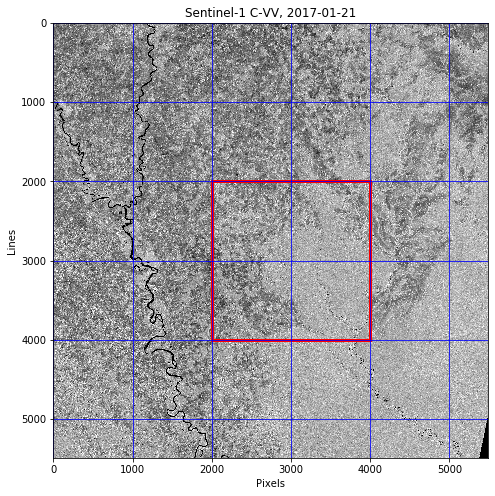

In [13]:
subset=(2000,2000,2000,2000)   # (xoff,yoff,xsize,ysize)
bandnbr=1

rasterDN=img.GetRasterBand(bandnbr).ReadAsArray()
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Sentinel-1 C-VV, {}'
             .format(tindex[bandnbr-1].date()))
ax.imshow(rasterDN,cmap='gray',vmin=2500,vmax=9000)
ax.grid(color='blue')
ax.set_xlabel('Pixels')
ax.set_ylabel('Lines')
# plot the subset as rectangle
if subset != None:
    _=ax.add_patch(patches.Rectangle((subset[0],subset[1]),
                                     subset[2],subset[3],
                                     fill=False,edgecolor='red',
                                     linewidth=3))

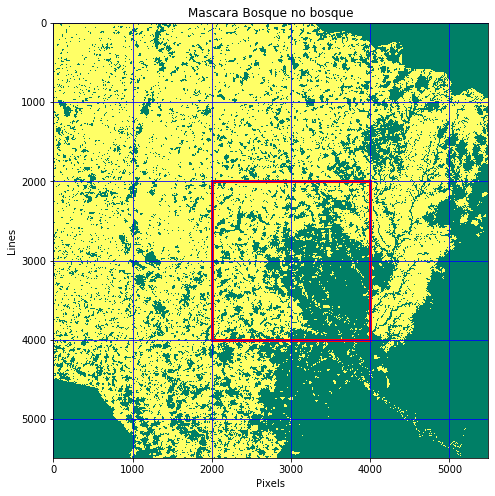

In [26]:
# MASCARAAAAAAAAAAAA
#subset=(2000,2000,2000,2000)   # (xoff,yoff,xsize,ysize)

rastermascara=mas.GetRasterBand(1).ReadAsArray()
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Mascara Bosque no bosque')
ax.imshow(rastermascara,cmap='summer',vmin=1,vmax=3)
ax.grid(color='blue')
ax.set_xlabel('Pixels')
ax.set_ylabel('Lines')
# plot the subset as rectangle
if subset != None:
    _=ax.add_patch(patches.Rectangle((subset[0],subset[1]),
                                     subset[2],subset[3],
                                     fill=False,edgecolor='red',
                                     linewidth=3))

In [29]:
T1=46
T2=72
rasterDN=img.ReadAsArray(*subset)
rasterDN_all=np.vstack((rasterDN[:2],rasterDN[6:]))
rasterDN=rasterDN_all[T1:T2]
tindex_all=tindexOrg[:2].append(tindexOrg[6:])
tindex=tindex_all[T1:T2]
mascarabnb=mas.ReadAsArray(*subset)
mask0 = mascarabnb==1
mask= (rasterDN & mask0)==0
CF=np.power(10.,-8.3)
rasterPwr=np.ma.array(np.power(rasterDN,2.)*CF,mask=mask,dtype=np.float32)

# Code below is an example to generate an 8bit scaled dB image
# rasterDB=(10.*np.ma.log10(rasterPwr)+31)/0.15   
# rasterDB[rasterDB<1.]=1.
# rasterDB[rasterDB>255.]=255.
# rasterDB=rasterDB.astype(np.uint8)
# rasterDB=rasterDB.filled(0)

We make an RGB stack to display the first, center, and last time step as a multi-temporal color composite.
The np.dstack results in an array of the form [lines,pixels,bands], which is the format we need for RGB display with matplotlib's imshow() function. Note that numpy array indexing starts with 0, so band 1 is raster[0]. 

In [30]:
rgb_bands=(1,int(rasterDN.shape[0]/2),rasterDN.shape[0])  # first, center, last band
rgb_bands=(1,2,25) 
rgb_idx=np.array(rgb_bands)-1  # get array index from bands by subtracting 1
rgb=np.dstack((rasterPwr[rgb_idx[0]],rasterPwr[rgb_idx[1]],rasterPwr[rgb_idx[2]]))
rgb[rgb<0.0001]=0.0001
rgb[rgb>1]=1
rgb_dates=(tindex[rgb_idx[0]].date(),
           tindex[rgb_idx[1]].date(),tindex[rgb_idx[2]].date())

We are also interested in displaying the image enhanced with histogram equalization. 
We can use the function *exposure.equalize_hist()* from the skimage.exposure module

In [31]:
rgb_stretched=rgb.copy()
# For each band we apply the strech
for i in range(rgb_stretched.shape[2]):
    rgb_stretched[:,:,i] = exposure.\
    equalize_hist(rgb_stretched[:,:,i].data,
    mask=~np.equal(rgb_stretched[:,:,i].data,0.))

Now let's display the the unstrechted and histogram equalized images side by side.

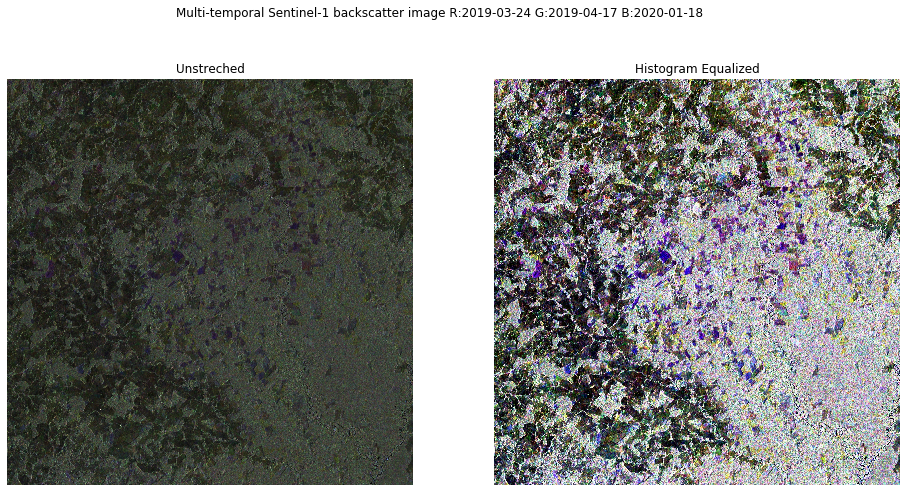

In [32]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Multi-temporal Sentinel-1 backscatter image R:{} G:{} B:{}'
             .format(rgb_dates[0],rgb_dates[1],rgb_dates[2]))
plt.axis('off')
ax[0].imshow(rgb,vmin=0,vmax=0.15)
ax[0].set_title('Unstreched')
ax[0].axis('off')
ax[1].imshow(rgb_stretched)
ax[1].set_title('Histogram Equalized')
_=ax[1].axis('off')

# Computation and Visualization of the Time Series Metrics

For the entire time series, we will compute some metrics that will aid us in change detection. For each pixel in the stack we compute:

- Mean 
- Median
- Maximum
- Minimum
- Range (Maximum - Minimum)
- 5th Percentile
- 95th Percentile
- PRange (95th - 5th Percentile)
- Variance
- Coefficient of Variation (Variance/Mean)

In [33]:
%%time 
metrics=timeseries_metrics(rasterPwr.filled(np.nan),ndv=np.nan)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: All-NaN slice encountered
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice.


Wall time: 11min 54s


In [34]:
%%time 
metrics.keys()

Wall time: 0 ns


dict_keys(['mean', 'max', 'min', 'range', 'median', 'p5', 'p95', 'prange', 'var', 'cov'])

Let's look at the histograms for the time series variance and coeficient of variation to aid displaying those images:

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


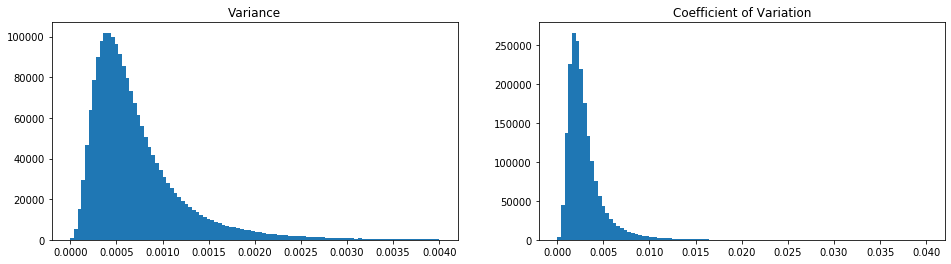

In [35]:
fig, ax= plt.subplots(1,2,figsize=(16,4))
ax[0].hist(metrics['var'].flatten(),bins=100,range=(0,0.004))
ax[1].hist(metrics['cov'].flatten(),bins=100,range=(0,0.04))
_=ax[0].set_title('Variance')
_=ax[1].set_title('Coefficient of Variation')

We use thresholds determined from those histograms to set the scaling in the time series visualiztion. For the backscatter metrics we choose a typeical range appropriate for this ecosystem and radar sensor. A typical range is -30 dB (0.0001) to -5.2 dB (0.3).

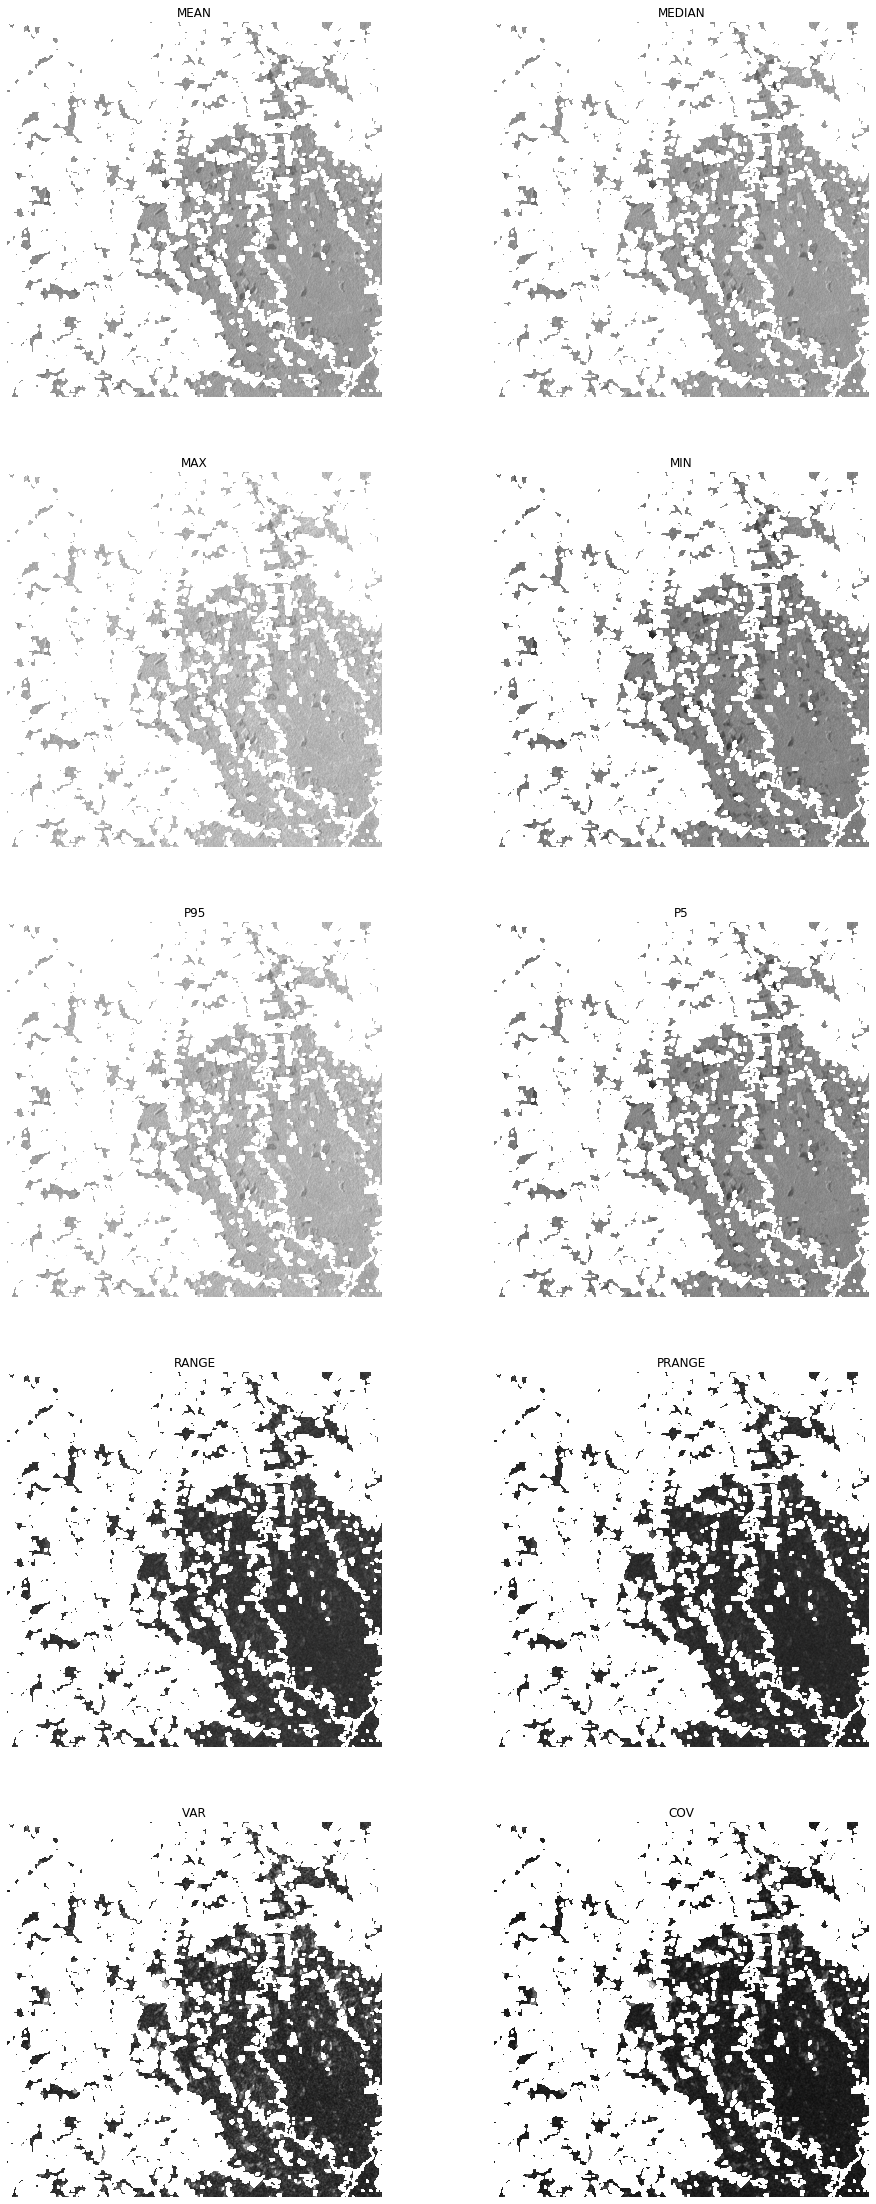

In [36]:
# List the metrics keys you want to plot
metric_keys=['mean', 'median', 'max', 'min', 
             'p95', 'p5','range', 'prange','var','cov']
fig= plt.figure(figsize=(16,40))
idx=1
for i in metric_keys:
    ax = fig.add_subplot(5,2,idx)
    if i=='var': vmin,vmax=(0.0,0.003)
    elif i == 'cov': vmin,vmax=(0.,0.02)
    else:
        vmin,vmax=(0.0001,0.4)
    ax.imshow(metrics[i],vmin=vmin,vmax=vmax,cmap='gray',interpolation='bilinear')
    ax.set_title(i.upper())
    ax.axis('off')
    idx+=1

# Change detection with the Percentile Difference Threshold Method

In this method we find thresholds on the 95$^{th}$ and 5$^{th}$ percentile difference. The advantage to look at percentiles verus maximum minus minimum is that outliers and extremas in the time series are not influencing the result.

For our example, the historgram of the 95$^{th}$ and 5$^{th}$ percentile difference image looks like this:

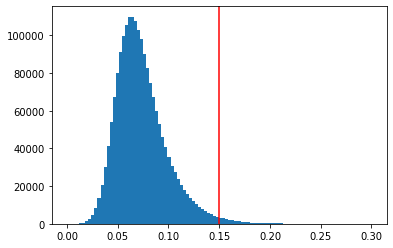

In [37]:
plt.hist(metrics['prange'].flatten(),bins=100,range=(0,0.3))
_=plt.axvline(0.15,color='red')

Let's visualize the change pixels (cp) where the 95th - 5th percentile difference in the time series for each pixel (x,y) exceed a threshold $t$

${cp}_{x,y} = P_{x,y}^{95th} - P_{x,y}^{5th} > t$ 

With $t=0.15$ the image looks like:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


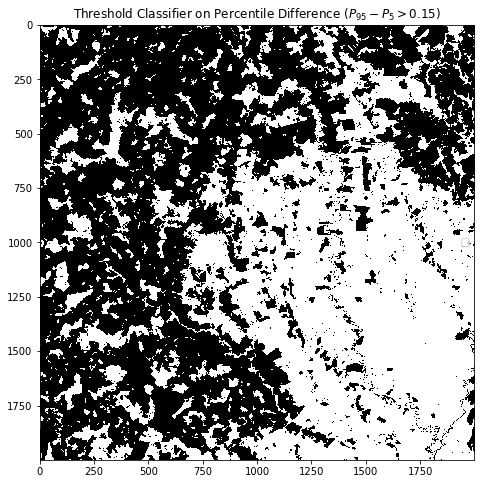

In [38]:
thres=0.15 #Mayor numero menos cambios (menor sensibilidad)
plt.figure(figsize=(8,8))
mask=metrics['prange']<thres  # For display we prepare the inverse mask
maskpdiff=~mask # Store this for later output
plt.imshow(mask,cmap='gray')
plt.legend(['$p_{95} - p_5 > 0.15$'],loc='center right')
_=plt.title('Threshold Classifier on Percentile Difference ($P_{95} - P_5 > 0.15$)')

In [39]:
print(maskpdiff)

[[ True  True False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


# Change Detection with the Coefficient of Variation Method

We can set a threshold $t$ for the coefficient of variation image
to classify change in the time series:
    
${cp}_{x,y} = \frac{\sigma_{x,y}^2}{\overline{X}_{x,y}} > t$ 

Let's look at the histogram of the coefficient of variation:

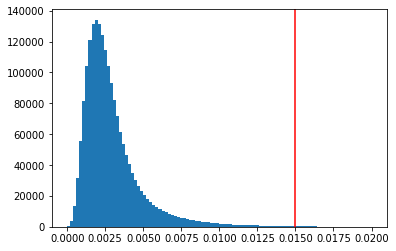

In [40]:
plt.hist(metrics['cov'].flatten(),bins=100,range=(0,0.02))
_=plt.axvline(0.015,color='red')

With a threshold t=0.015 the change pixels would look like the following image:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


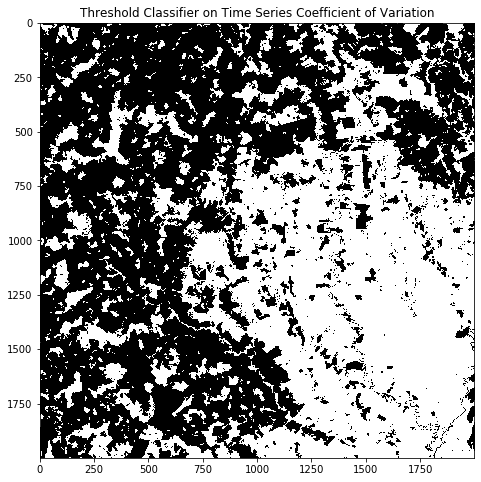

In [41]:
thres=0.01 #A menor numero mayores cambios
mask=metrics['cov'] < thres
maskcv=~mask
plt.figure(figsize=(8,8))
plt.imshow(mask,cmap='gray')
_=plt.title('Threshold Classifier on Time Series Coefficient of Variation')

In [42]:
print(tindex[0],tindex[-1])

2019-03-24 00:00:00 2020-01-30 00:00:00


# Change Detection with the Log Ratio Method

We compare two images from the same season in different years. First we look at global means of the backscatter images in the subset building a time series object of acquisition dates and global image means of backscatter.

In [43]:
%%time 
tsmean=10*np.log10(np.nanmean(rasterPwr.filled(np.nan),axis=(1,2)))

Wall time: 3.7 s


We make a time series object to list the dates, mean backscatter in dB and band index number for the rasterPwr array:

In [44]:
ts = pd.Series(tsmean,index=tindex)
for i in range(len(ts)):
    print(i,ts.index[i].date(),ts[i])

0 2019-03-24 -6.1448774
1 2019-04-17 -5.830626
2 2019-04-29 -6.0472994
3 2019-05-11 -6.2417326
4 2019-05-23 -6.197593
5 2019-06-04 -5.8423257
6 2019-06-16 -6.042633
7 2019-06-28 -6.291725
8 2019-07-10 -6.2971377
9 2019-07-22 -5.882563
10 2019-08-03 -6.1206617
11 2019-08-15 -6.3499365
12 2019-08-27 -6.1382236
13 2019-09-08 -6.104966
14 2019-09-20 -6.384305
15 2019-10-02 -6.1812377
16 2019-10-14 -6.528185
17 2019-10-26 -6.347279
18 2019-11-07 -6.2076025
19 2019-11-19 -5.8191776
20 2019-12-01 -6.1606464
21 2019-12-13 -6.585002
22 2019-12-25 -6.1612487
23 2020-01-06 -6.7050037
24 2020-01-18 -6.4771695
25 2020-01-30 -6.5692434


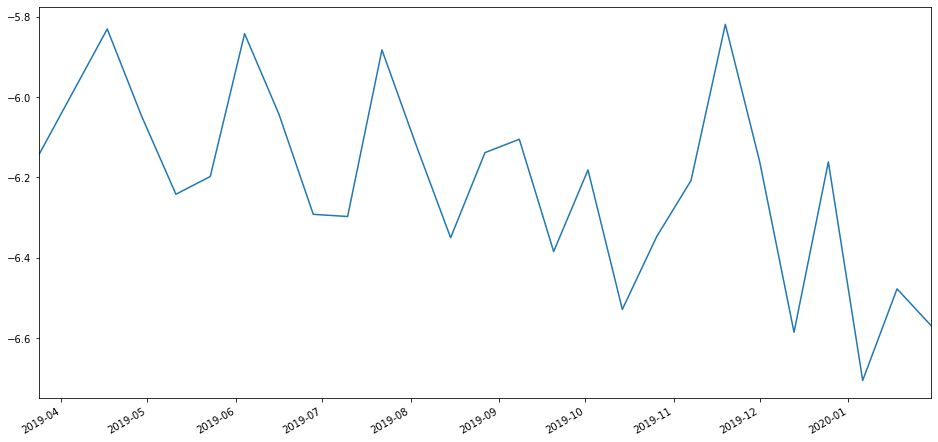

In [45]:
plt.figure(figsize=(16,8))
ts.plot()

## To compare two dates for change detection with the log ratio approach we pick two dates of relative low backscatter (dry conditions) and from similar times of the year. Two such candidate dates are

- t1: 
- t2: 

In [46]:
# # Cross-polarized Descending
# Xr=rasterPwr[36]   # Reference Image
# Xi=rasterPwr[52]  # New Image
# Like-polarized Ascending 
Xr=rasterPwr[0]   # Reference Image
Xi=rasterPwr[23]  # New Image



The Log ratio between the images is 

$r  = log_{10}(\frac{X_i}{X_r})$

In [47]:
r = np.log10(Xi/Xr)

To find a threshold for change, we can display the absolute ration image $abs(r)$ and the historgram of $r$. We adjust the scale factors for the display to enhance visualization of change areas with largest backscatter change over the time series. Brighter values show larger change.

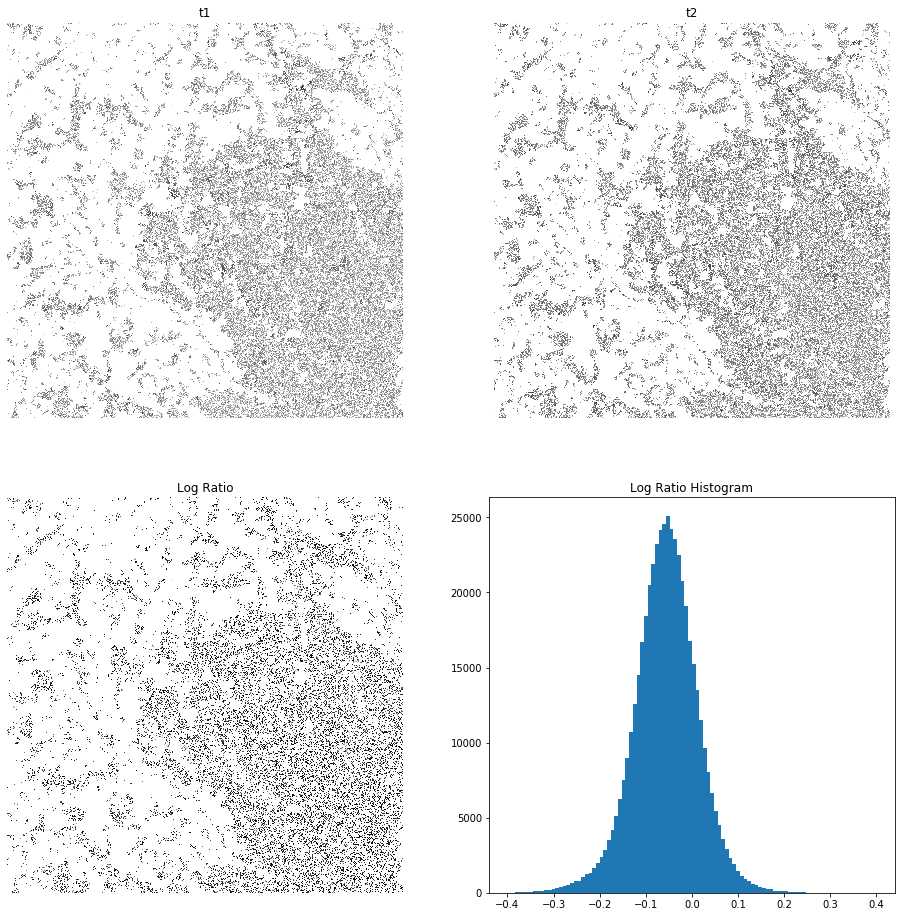

In [50]:
# Display r
fig, ax = plt.subplots(2,2,figsize=(16,16))
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[0][0].set_title('t1')
ax[0][0].imshow(Xr,vmin=0,vmax=0.4,cmap='gray')
ax[0][1].set_title('t2')
ax[0][1].imshow(Xi,vmin=0,vmax=0.4,cmap='gray')
ax[1][0].set_title('Log Ratio')
ax[1][0].imshow(np.abs(r),vmin=0,vmax=0.4,cmap='gray')
ax[1][1].set_title('Log Ratio Histogram')
_=ax[1][1].hist(r.flatten(),bins=100,range=(-0.4,0.4))

Let's define change pixels as those falling outside the range of *three* times the standard deviation of the ration image $\sigma_r$ from the image mean $\bar{r}$:

${cp}_{x,y} = (r_{x,y} < \overline{r} - 2\sigma_r) \ \textrm{or} \ (r_{x,y} > \overline{r} + 2\sigma_r)$ 

We are using the numpy masking to set the non-changing pixels inside the range:

In [51]:
stddev=np.std(r)
thres=2*stddev
mask=np.logical_and(r>-1*thres,r<thres)
masklr=~mask

Let's display pixels that fall outside 2 times the standard deviation

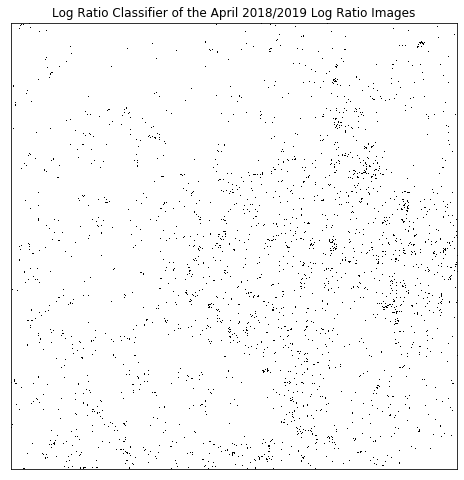

In [52]:
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(mask,cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
_=ax.set_title('Log Ratio Classifier of the April 2018/2019 Log Ratio Images')

# Difference in time series COV between two years

Another good approach to assess change between two years is to look at the coefficient of variation between the two years and threshold a difference image of the 2

$Change =COV_{Year_2} - COV_{Year_1} > threshold$

In the cells below we compute the COVs for t1 and t2, look at the difference and select a threshold for change.


In [53]:
# Let's print the dates again:
print('Bands and dates for',imagefile)
j=1
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for 18NWG_20m_D_069_vv_mtfil.vrt
   1 2019-03-24    2 2019-04-17    3 2019-04-29    4 2019-05-11    5 2019-05-23 
   6 2019-06-04    7 2019-06-16    8 2019-06-28    9 2019-07-10   10 2019-07-22 
  11 2019-08-03   12 2019-08-15   13 2019-08-27   14 2019-09-08   15 2019-09-20 
  16 2019-10-02   17 2019-10-14   18 2019-10-26   19 2019-11-07   20 2019-11-19 
  21 2019-12-01   22 2019-12-13   23 2019-12-25   24 2020-01-06   25 2020-01-18 
  26 2020-01-30 

In [54]:
# Colombia Descending VV
idx_t1=[1,5]
idx_t2=[16,26]

 
rp_t1=rasterPwr[idx_t1[0]:idx_t1[1]]
rp_t2=rasterPwr[idx_t2[0]:idx_t2[1]]
tsm_t1=timeseries_metrics(rp_t1)
tsm_t2=timeseries_metrics(rp_t2)

In [55]:
cov_t1=tsm_t1['cov']
cov_t2=tsm_t2['cov']

In [154]:
cov_t2t1=cov_t2-cov_t1


Text(0.5, 1.0, 'Coefficient of Variation T2-T1')

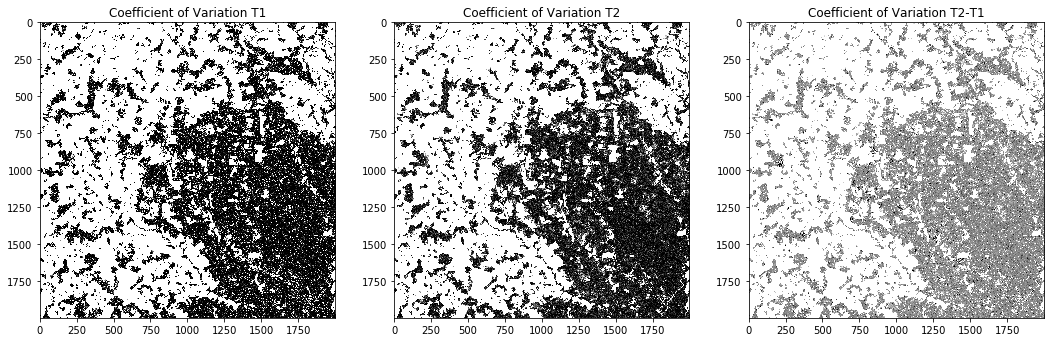

In [142]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(cov_t1  ,cmap='gray',vmin=0.001,vmax=0.01)
ax[1].imshow(cov_t2  ,cmap='gray',vmin=0.001,vmax=0.01)
ax[2].imshow(cov_t2t1,cmap='gray',vmin=-0.01,vmax=0.01)
ax[0].set_title('Coefficient of Variation T1')
ax[1].set_title('Coefficient of Variation T2')
ax[2].set_title('Coefficient of Variation T2-T1')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


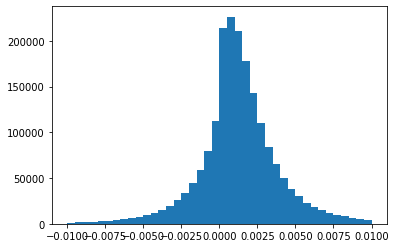

In [141]:
_=plt.hist(cov_t2t1.flatten(),range=(-0.01,0.01), bins=40)

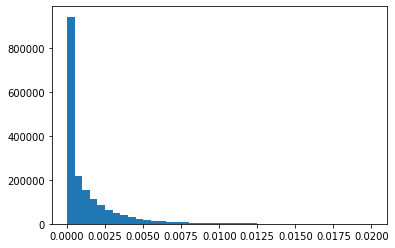

In [59]:
_=plt.hist(cov_t1.flatten(),range=(0,0.02), bins=40)

Mask 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


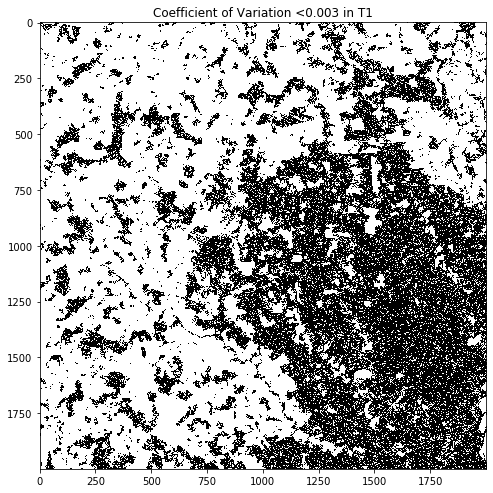

In [140]:
mask=cov_t1<0.003

mask_t1=mask
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~mask  ,cmap='gray')
_=ax.set_title('Coefficient of Variation <0.003 in T1')

Produce a mask where the COV has increased from 2017 to 2019:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


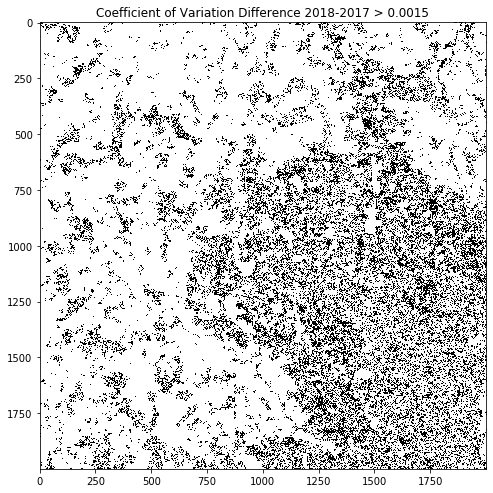

In [139]:
mask=cov_t2t1>0.0015

maskcv_t2t1=mask

fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~mask  ,cmap='gray')
_=ax.set_title('Coefficient of Variation Difference 2018-2017 > 0.0015')

Combine the masks:

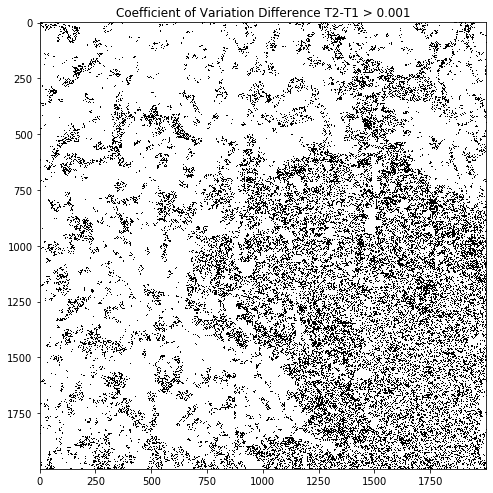

In [129]:
maskcvt2t1andt1=mask_t1 & maskcv_t2t1
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~maskcvt2t1andt1  ,cmap='gray')
_=ax.set_title('Coefficient of Variation Difference T2-T1 > 0.001')

# Write  the images to an output file

## Determine output geometry 

First, we need to set the correct geotransformation and projection information. We retrieve the values from the input images and adjust by the subset:

In [149]:
proj=img.GetProjection()
geotrans=list(img.GetGeoTransform())

subset_xoff=geotrans[0]+subset[0]*geotrans[1]  
subset_yoff=geotrans[3]+subset[1]*geotrans[5] 
geotrans[0]=subset_xoff
geotrans[3]=subset_yoff
geotrans=tuple(geotrans)
geotrans

AttributeError: 'numpy.ndarray' object has no attribute 'GetProjection'

In [131]:
rasterPwr.shape

(26, 2000, 2000)

## Time series metrics images

We use the root of the time series data stack name and append a _ts_metrics_<metric>.tif ending as filenames

In [132]:
# Time Series Metrics as image image:
# We make a new subdirectory where we will store the images
dirname=imagefile.replace('.vrt','tsmetrics_maskCF')
os.makedirs(dirname,exist_ok=True)
print(dirname)

18NWG_20m_D_069_vv_mtfiltsmetrics_maskCF


### Output the individual metrics as GeoTIFF images:

In [133]:
Names=[] # List to keep track of all the names
for i in metrics:
    # Name, Array, DataType, NDV,bandnames=None,ref_image
    Name=os.path.join(dirname,imagefile.replace('.vrt','_'+i+'.tif'))
    CreateGeoTiff(Name,metrics[i],gdal.GDT_Float32,np.nan,[i],GeoT=geotrans,Projection=proj)
    Names.append(Name)

### Build a Virtual Raster Table on the Metrics GeoTIFF images

To tie the images in to one new raster stack of time series metrics we build a virtual raster table with all the metrics. 

Trick: Use ' '.join(Names) to build one long string of names separated by a space as input to *gdalbuildvrt*

In [134]:
cmd='gdalbuildvrt -separate -overwrite -vrtnodata nan '+\
   dirname+'.vrt '+' '.join(Names)
# print(cmd)
os.system(cmd)

0

In [135]:
os.getcwd()

'C:\\Users\\crist\\Documents\\Python Scripts\\1_servir_training-master\\Prueba_PatNat\\18NWG_20m_D_069'

In [136]:
print('Time Series Metrics VRT File:\n',dirname+'.vrt')

Time Series Metrics VRT File:
 18NWG_20m_D_069_vv_mtfiltsmetrics_maskCF.vrt


## Change Images from the four methods

We are going to write one three-band GeoTIFF output file that stores the results from the three classifiers

In [137]:
imagename=imagefile.replace('vrt','thresholds_maskCF.tif')
bandnames=['Percentile','COV','Log Ratio','COV Diff']
Array=np.array([maskpdiff,maskcv,masklr,maskcvt2t1andt1])
CreateGeoTiff(imagename,Array,gdal.GDT_Byte,0,bandnames=bandnames,GeoT=geotrans,Projection=proj)

'18NWG_20m_D_069_vv_mtfil.thresholds_maskCF.tif'

This Image can now be loaded into QGIS or other Tools and only the detected layers should show.

## COV Difference image 2017-2018

In [158]:
imagename=imagefile.replace('.vrt','T1-T2_COVmaskCF2.tif')
bandnames=['COV_2017','COC_2018','COV T2-T1']
Array=np.array([cov_t1,cov_t2,cov_t2t1])*100000
CreateGeoTiff(imagename,Array,gdal.GDT_UInt16,np.nan,bandnames=bandnames,GeoT=geotrans,Projection=proj)

'18NWG_20m_D_069_vv_mtfilT1-T2_COVmaskCF2.tif'

# Conclusion

Thresholds for the three methods are necessarily site dependent and need to be identified with calibration data or visual post-classification interpretation, and can subsequently be adjusted to maximize classification accuracy. Also, some methods will have advantages in different scenarios. 

At the Earth Big Data SEPPO Processor we actually transform many of the time series metrics data types back to lower volume storage models, e.g. 16 bit scaled amplitudes. See the [EBD Data Guide here.](https://github.com/EarthBigData/openSAR/blob/master/documentation/EBD_DataGuide.md) (also available as [pdf](https://github.com/EarthBigData/openSAR/blob/master/documentation/EBD_DataGuide.pdf))

# Exercises
- Change the threshold and band choices in this notebook to see the effects on detected changes. 
- Load  masks  on the  with QGIS and compare the detected areas with your time series plots and image data in QGIS.
- Look at the effect of using cross-polarized versus like-polarized polarizations 

In [159]:
import pandas as pd
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
# Read in raster image 
img_ds = gdal.Open('18NWG_20m_D_069_vv_mtfilT1-T2_COVmaskCF2.tif', gdal.GA_ReadOnly)


In [161]:
band = img_ds.GetRasterBand(3)

img = band.ReadAsArray()
print (img.shape)
X = img.reshape((-1,1))

print (X)
print (X.shape)

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)


X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

(2000, 2000)
[[  0]
 [  0]
 [154]
 ...
 [207]
 [  0]
 [  0]]
(4000000, 1)
2000


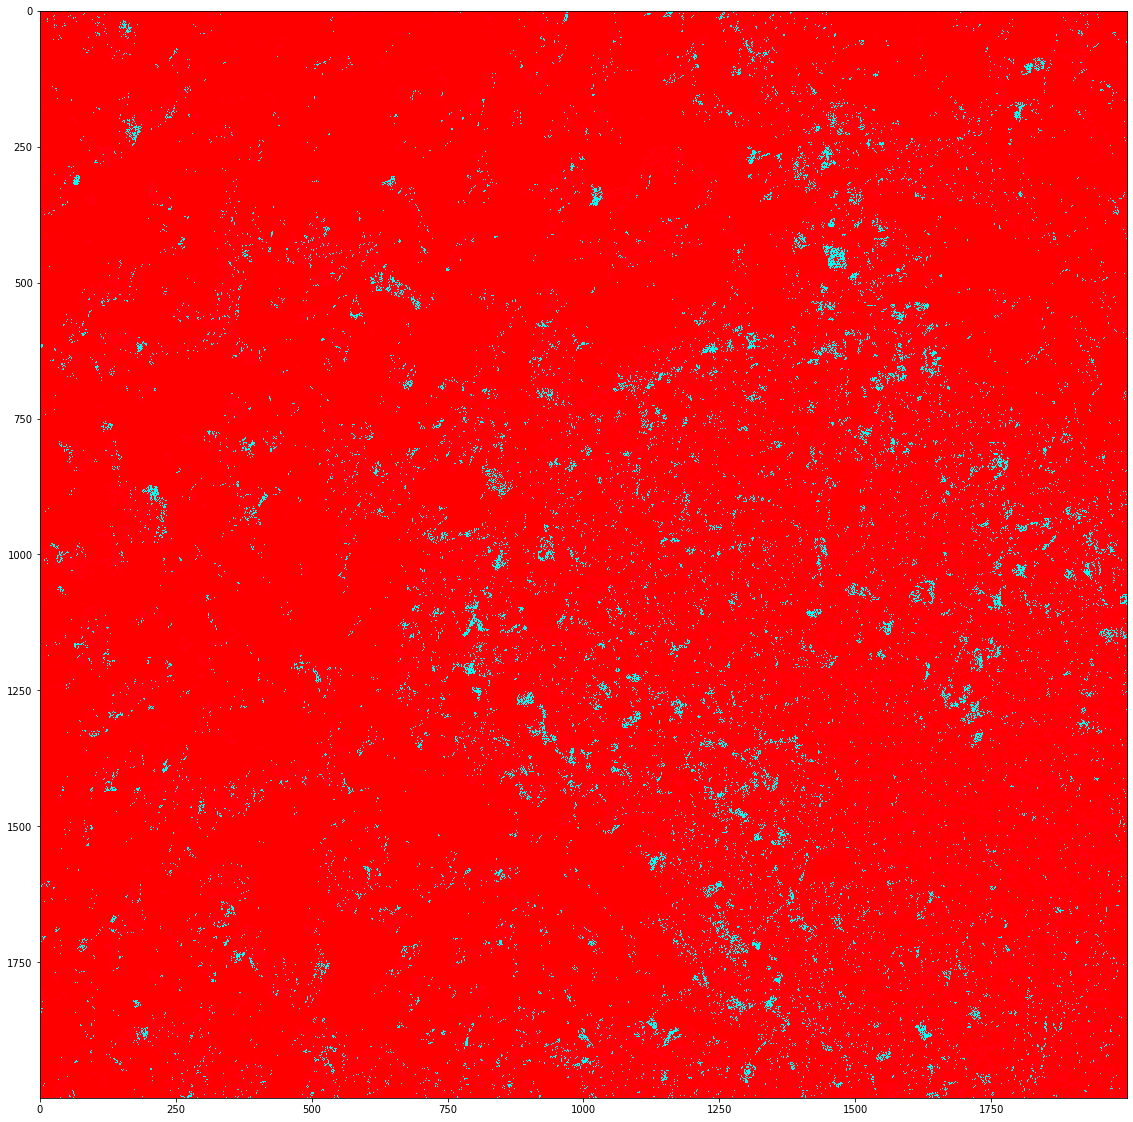

In [162]:
%matplotlib inline  

import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [26]:

imagename=imagefile.replace('vrt','kmeans.tif')
bandnames=['kmeans']
Array=np.array([X_cluster])
CreateGeoTiff(imagename,Array,gdal.GDT_Byte,0,bandnames=bandnames,GeoT=geotrans,Projection=proj)

'18NWG_20m_D_069_vv_mtfil.kmeans.tif'